In [1]:
import numpy as np
import pandas as pd

In [2]:
class Neural_Network:
    
    
    def __init__(self,shapes,activations):
        if(len(shapes)-1!=len(activations)):
            print('error: Shape and Activation do not match')
        self.shapes = shapes
        self.activations = activations
        self.modelweights = []
        self.modelbias = []
    
    def show_details(self):
        print(self.shapes.shape)
        print(self.activations)
        
    def initialize_weights_and_bias(self):
        weights = []
        bias = []
        for i in range(self.shapes.shape[0]-1):
            variance = np.sqrt(2/(self.shapes[i]+self.shapes[i+1]))
            initial_weights = np.random.normal(0,variance,self.shapes[i]*self.shapes[i+1])
            weights.append(initial_weights.reshape(self.shapes[i],self.shapes[i+1]))
            bias.append(np.zeros(self.shapes[i+1]))
        return weights,bias
    
    def loss(self,Hypothesis,y):
        return - np.sum(np.multiply(np.log(Hypothesis+1e-10) , (y)), axis=1)
    
    def softmax(x):
        x = x.transpose()
        maxima = np.amax(x,axis=0)
        x = x-maxima
        numerator = np.exp(x)
        return (numerator/numerator.sum(axis=0)).transpose()
    
    def tanh(x):
        x = -2*x
        denom = 1+np.exp(x)
        num = (2/denom)-1
        return num

    activation_map = {'softmax': softmax,'tanh': tanh}
    
    def forward_pass(self,X,weights,bias):
        cached_output = []
        cached_output_activated = []
        for i in range(len(weights)):
            temp = X@np.array(weights[i])+np.array(bias[i])
            cached_output.append(temp)
            temp = self.activation_map[self.activations[i]](temp)
            cached_output_activated.append(temp)
            X = temp
        #print(cached_output_activated[2].shape)
        return cached_output,cached_output_activated
    
    def softmax_input_derivative(self,cached_output_activated,y):
        return (1/y.shape[0]) * (cached_output_activated[len(cached_output_activated)-1]-y)
    
    def tanh_input_derivative(self,cached_activated):
        return 1-cached_activated**2
    
    def backprop(self,X,y,weights,bias,cached_output,cached_output_activated,l):
        derivative_at_softmax_input = self.softmax_input_derivative(cached_output_activated,y)
        #for i in range(len(self.activations)-1,-1,-1):
    
        d_w2 = np.matrix(cached_output_activated[1]).transpose()@np.matrix(derivative_at_softmax_input)
        weights[2] = weights[2] - l*d_w2
        bias[2] = bias[2] - np.mean(l*derivative_at_softmax_input,axis=0)
        
        derivative_at_tanh_input1 = np.multiply(np.matrix(derivative_at_softmax_input)@weights[2].transpose(),np.matrix(self.tanh_input_derivative(cached_output_activated[1])))
        
        d_w1 = np.matrix(cached_output_activated[0]).transpose()@ derivative_at_tanh_input1
        weights[1] = weights[1] - l*d_w1
        bias[1] = bias[1] - l*np.mean(derivative_at_tanh_input1)
        
        derivative_at_tanh_input0 = np.multiply(np.matrix(derivative_at_tanh_input1)@weights[1].transpose(),np.matrix(self.tanh_input_derivative(cached_output_activated[0])))
        
        d_w0 = np.matrix(X).transpose()@ derivative_at_tanh_input0
        weights[0] = weights[0] - l*d_w0
        bias[0] = bias[0] - l*np.mean(derivative_at_tanh_input0)
        
        return weights,bias
    
    def set_parameters(self,weights_,bias_):
        self.modelweights = weights_
        self.modelbias = bias_
        
    def predict(self,X):
        cached_output_not_used,cached_output_activations = self.forward_pass(X,self.modelweights,self.modelbias)
        return cached_output_activations[2]
        
    def fit(self,X,y,batch_size,learning_rate,epochs):
        weights,bias = self.initialize_weights_and_bias()
        loss = np.zeros(epochs)
        for i in range(epochs):
            if(i%50 == 0):
                learning_rate/= 10
            for j in range(0,X.shape[0],batch_size):
                cached_output,cached_output_activated = self.forward_pass(X[j:j+batch_size,:],weights,bias)
                weights,bias = self.backprop(X[j:j+batch_size,:],y[j:j+batch_size,:],weights,bias,cached_output,cached_output_activated,learning_rate)
            loss[i] = np.mean(self.loss(self.forward_pass(X,weights,bias)[1][2],y))
        self.set_parameters(weights,bias)
        return loss
        #print(weights,bias)
        #return weights,bias

In [3]:
Shape = np.array([784,200,200,10])
Activation = np.array(['tanh','tanh','softmax'])
model = Neural_Network(Shape,Activation)
#weights,bias = model.initialize_weights_and_bias()

In [4]:
def createOneHotVectors(x):
    mat = np.zeros((x.shape[0],np.max(np.array(x))+1))
    mat[np.arange(x.shape[0]),x.flatten()] = 1
    return mat

Test_data = np.array(pd.read_csv('mnist/mnist-test-data.csv',sep = " ",header = None))/255
Test_labels = createOneHotVectors(np.array(pd.read_csv('mnist/mnist-test-labels.csv',sep = " ",header = None)))
Train_data = np.array(pd.read_csv('mnist/mnist-train-data.csv',sep = " ",header = None))/255
Train_labels = createOneHotVectors(np.array(pd.read_csv('mnist/mnist-train-labels.csv',sep = " ",header = None)))

In [5]:
loss = model.fit(Train_data,Train_labels,200,1,100)

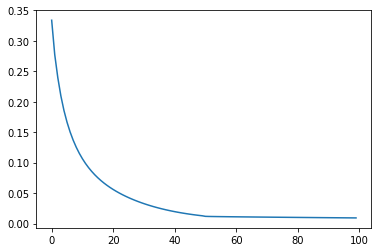

In [13]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.show()

In [19]:
1-np.count_nonzero(np.argmax(Train_labels,axis=1).reshape(1,50000)!=np.argmax(model.predict(Train_data),axis=1))/50000

0.99928

In [14]:
1-np.count_nonzero(np.argmax(Test_labels,axis=1).reshape(1,10000)!=np.argmax(model.predict(Test_data),axis=1))/10000

0.9788

In [15]:
np.count_nonzero(np.argmax(Test_labels,axis=1).reshape(1,10000)!=np.argmax(model.predict(Test_data),axis=1))

212

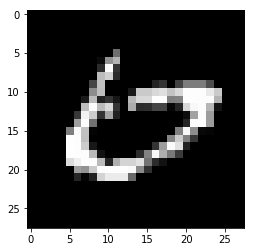

In [16]:
HardExamples = (np.argmax(Test_labels,axis=1).reshape(1,10000)!=np.argmax(model.predict(Test_data),axis=1))
Hard_test_data = Test_data[HardExamples.flatten()]
Hard_test_data = Hard_test_data.reshape(-1,28,28)
plt.imshow(Hard_test_data[6],cmap='gray')
plt.show()

In [17]:
model.predict(Test_data[HardExamples.flatten()])[6]

array([9.97951340e-01, 6.50746761e-10, 2.87412128e-08, 4.62061663e-08,
       4.93025236e-07, 2.33590369e-04, 1.79614818e-03, 6.51765167e-06,
       9.16310287e-06, 2.67252739e-06])

In [18]:
Test_labels[HardExamples.flatten()][6]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])